In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from fixed_support import fixed_support

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

# Choose training set by percentage of data for training
p_training = .2
k_training = int(p_training*len(digits.target))

# Choose testing set by net ammount
n_test = 200

In [3]:
target_train = digits.target[0:k_training]
images_train = digits.images[0:k_training]

target_test = digits.target[k_training:k_training + n_test]
images_test = digits.images[k_training:k_training + n_test]

(array([19., 18., 19., 18., 21., 22., 19., 19., 22., 23.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

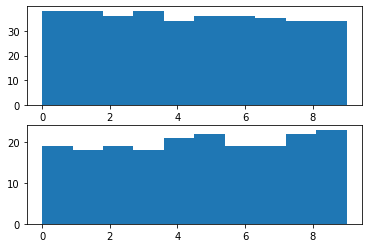

In [4]:
fig, ax = plt.subplots(2)

ax[0].hist(target_train, bins = 10)
ax[1].hist(target_test, bins = 10)

## Training

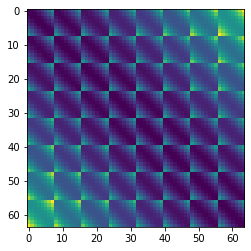

In [5]:
N = len(np.array(digits.images[0].flatten()))

# Define support for xi
N_euc = int(np.sqrt(N))

# Create cost matrix (l-2 norm used for the moment)
c = np.zeros((N, N))
for i, mi in enumerate(list(product(np.arange(N_euc), np.arange(N_euc)))):
    for j, mj in enumerate(list(product(np.arange(N_euc), np.arange(N_euc)))):
        c[i, j] = np.linalg.norm(np.array(mi)- np.array(mj), 2)**2 # l-2 norm

# Plot
plt.imshow(c)

In [6]:
typical_p = []
# select cifre to analyze
for digit in range(10):
    # Save p_k
    p_k = [np.array(images_train[k].flatten())/sum(np.array(images_train[k].flatten())) 
           for k in np.where(target_train == digit)[0][0:]]

    r, p = fixed_support(c, p_k)
    typical_p.append(p)
    


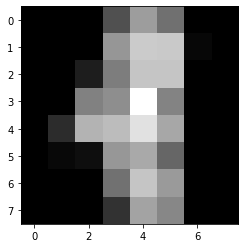

In [7]:
p = typical_p[1]
p_opt = [p[i*N_euc:N_euc*(i + 1)] for i in range(N_euc)]
plt.gray()
plt.imshow(p_opt)

## Testing

In [8]:
import cvxpy as cp

def wasserstein_dist(c, p, p_k):
    N = len(p_k)

    # Dec Var
    T = cp.Variable((N, N))

    # Obj
    obj = cp.Minimize(cp.trace(c.T@T))
    #obj = cp.Minimize(sum(sum(cp.multiply(T, c))))

    # Cons
    cons = [T >= 0]
    cons.append(T@np.ones(N) == p)
    cons.append(T.T@np.ones(N) == p_k)

    # Solve program
    problem = cp.Problem(obj, cons)
    problem.solve(solver = cp.SCIPY, scipy_options={"method": "highs"})

    return obj.value

In [9]:
#from fixed_support import wasserstein_dist
k =18

p_k = np.array(images_test[k].flatten())/sum(np.array(images_test[k].flatten()))

In [10]:
a = wasserstein_dist(c, typical_p[9], p_k)

In [11]:
digit_result = []
for image in images_test:
    p_k = np.array(image.flatten())/sum(np.array(image.flatten()))
    classifier = [wasserstein_dist(c, typical_p[k], p_k) for k in range(10)]
    digit_result.append(np.argmin(classifier))

In [12]:
a = len(digit_result)

In [13]:
accuracy = 1 - len(np.nonzero(target_test[0:a] - digit_result)[0])/len(digit_result)
print(accuracy)

0.725
